In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cv2
import torch
import torch.functional as F
import torch.nn as nn
from torch.optim import Adam
from time import time, sleep

from utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader
from autoencoders import *

### Example of video transformation

In [ ]:
model = custom_pca()

video = VideoLoader('data/sample20s.mp4', grayscale=True)
t1 = time()
frames_rand = video.get_random_frames(0.6)
model.fit(frames_rand)
t2 = time()
reconstructed = []
for j, frames in enumerate(video):
    reconstructed.append(model.inverse_transform(model.transform(frames), shape=(video.height, video.width)))
reconstructed = np.vstack(reconstructed)
t3 = time()
print(reconstruction_error(video.get_all_frames(), reconstructed))
t4 = time()

print('Fitting time:', t2-t1)
print('Transform:', t3-t2)
print('Error calculation:', t4-t3)

### Dimensionality reduction using autoencoders

#### Consecutive load

Number of parameters for 16 components: 56466
Average loss per pixel at epoch 1: 57.70232963562012
Average loss per pixel at epoch 2: 49.1624118141506
Average loss per pixel at epoch 3: 44.3708496923032
Average loss per pixel at epoch 4: 43.27957932845406
Average loss per pixel at epoch 5: 43.63873929562776
Error after 5 epochs: 40.391567
Time taken for fitting with 6 epochs: 339.867027759552 sec
Time taken to transform: 132.30144000053406 sec


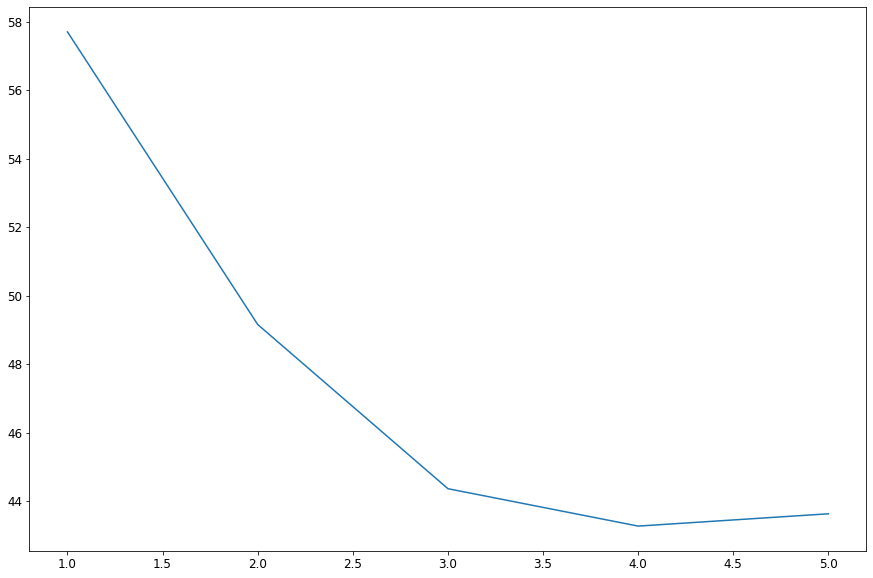

In [13]:
video = VideoLoader('data/big_sample_256.mp4', grayscale=True, duration=60*5, skip_frame=4)
num_epoch = 5
ncomp = 16
network = BasicAutoEncoder(1, ncomp)
optimizer = Adam(network.parameters(), lr=0.0005)

print(f'Number of parameters for {network.ncomp} components:', sum([p.numel() for p in network.parameters()]))
losses = []
networks = []
start = time()
for i in range(num_epoch):
    batch_losses = []
    for x in video:
        x = torch.from_numpy(x).float().unsqueeze(1)
        x_low, shape = network.transform(x)
        x_reconstructed = network.inverse_transform(x_low, shape)
        batch_loss = crit(x_reconstructed, x)
        batch_losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    losses.append(np.mean(batch_losses))
    print(f'Average loss per pixel at epoch {i+1}:', losses[-1])

fitting_time = time() - start

video.randit = video.skip_frame = 0
start = time()
reconstructed = []
for x in video:
    x = torch.from_numpy(x).float().unsqueeze(1)
    x_low, shape = network.transform(x)
    reconstructed.append(network.inverse_transform(x_low, shape).squeeze(1).detach().numpy())
reconstructed = np.vstack(reconstructed)
transform_time = time() - start

exact_loss = reconstruction_error(reconstructed,
                                  video.get_all_frames())
print("Error after %s epochs:" % num_epoch, exact_loss)
      
print(f'Time taken for fitting with {num_epoch+1} epochs:', fitting_time, 'sec')
print('Time taken to transform:', transform_time, 'sec')
losses = np.array(losses)
    
plot(range(1, num_epoch+1), [losses])

In [14]:
write_video('data/big_sample_net_16_consecutive.mp4', reconstructed, video.width, video.height, video.fps, grayscale=True)

#### Random loading

Number of parameters for 16 components: 56466
Average loss per pixel at epoch 1: 54.35461176996646
Average loss per pixel at epoch 2: 43.69000128041143
Average loss per pixel at epoch 3: 38.44324775364088
Average loss per pixel at epoch 4: 36.00181164948837
Average loss per pixel at epoch 5: 35.299047055451766
Error after 5 epochs: 36.036667
Time taken for fitting with 6 epochs: 323.3840343952179 sec
Time taken to transform: 127.41375637054443 sec


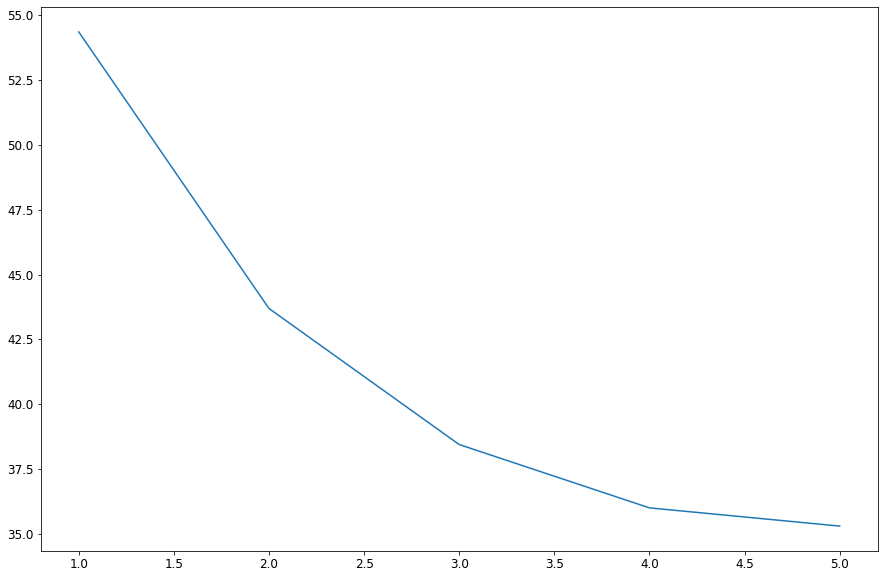

In [9]:
video = VideoLoader('data/big_sample_256.mp4', grayscale=True, duration=60*5, skip_frame=4, randit=True)
num_epoch = 5
ncomp = 16
network = BasicAutoEncoder(1, ncomp)
optimizer = Adam(network.parameters(), lr=0.0005)


print(f'Number of parameters for {network.ncomp} components:', sum([p.numel() for p in network.parameters()]))
losses = []
networks = []
start = time()
for i in range(num_epoch):
    batch_losses = []
    num_in_batch = []
    for x in video:
        num_in_batch.append(x.shape[0])
        x = torch.from_numpy(x).float().unsqueeze(1)
        x_low, shape = network.transform(x)
        x_reconstructed = network.inverse_transform(x_low, shape)
        batch_loss = crit(x_reconstructed, x)
        batch_losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    losses.append(np.mean(batch_losses))
    print(f'Average loss per pixel at epoch {i+1}:', losses[-1])

fitting_time = time() - start

video.randit = video.skip_frame = 0
start = time()
recskip_frametructed = []
for x in video:
    x = torch.from_numpy(x).float().unsqueeze(1)
    x_low, shape = network.transform(x)
    reconstructed.append(network.inverse_transform(x_low, shape).squeeze(1).detach().numpy())
reconstructed = np.vstack(reconstructed)
transform_time = time() - start

exact_loss = reconstruction_error(reconstructed,
                                  video.get_all_frames())
print("Error after %s epochs:" % num_epoch, exact_loss)
      
print(f'Time taken for fitting with {num_epoch+1} epochs:', fitting_time, 'sec')
print('Time taken to transform:', transform_time, 'sec')
losses = np.array(losses)
    
plot(range(1, num_epoch+1), [losses])

In [12]:
write_video('data/big_sample_net_16.mp4', reconstructed, video.width, video.height, video.fps, grayscale=True)